# Color Pallet
Jakub Darul 

Lab4 - K-means

In [64]:
from lab2.img_utils import  load_all,get_X_y,get_points
from lab2.rounding_utils import round_means_and_std_devs
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.pylab as pylab
import matplotlib.image as mimg
from sklearn.metrics import davies_bouldin_score,silhouette_samples
import numpy as np
np.seterr('ignore')
np.seterr(divide='ignore')
from typing import Optional,List,Dict,Tuple,Callable
import kmedoids
import matplotlib.colors as mcolors
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.decomposition import PCA

In [38]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# https://matplotlib.org/gallery/color/named_colors.html
def plot_colortable(colors:List[np.ndarray], title,  emptycols=0):

    cell_width = 212
    cell_height = 22
    swatch_width = 48
    margin = 12
    topmargin = 40

    # Sort colors by hue, saturation, value and name.
    by_hsv = [mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3])
                    for color in colors]

    n = len(colors)
    ncols = 4 - emptycols
    nrows = n // ncols + int(n % ncols > 0)

    width = cell_width * 4 + 2 * margin
    height = cell_height * nrows + margin + topmargin
    dpi = 72

    fig, ax = plt.subplots(figsize=(width / dpi, height / dpi), dpi=dpi)
    fig.subplots_adjust(margin/width, margin/height,
                        (width-margin)/width, (height-topmargin)/height)
    ax.set_xlim(0, cell_width * 4)
    ax.set_ylim(cell_height * (nrows-0.5), -cell_height/2.)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.set_axis_off()
    ax.set_title(title, fontsize=24, loc="left", pad=10)

    for i,color in enumerate(colors):
        row = i % nrows
        col = i // nrows
        y = row * cell_height

        swatch_start_x = cell_width * col
        swatch_end_x = cell_width * col + swatch_width
        text_pos_x = cell_width * col + swatch_width + 7

        ax.hlines(y, swatch_start_x, swatch_end_x,
                  color=color, linewidth=18)

    return fig



Wykorzystałem obrazek z natłokiem zieleni i niebieskiego, a na środku wyróżniające się z tła balony jako anomalia.

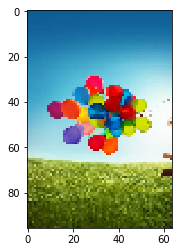

In [71]:
img =mimg.imread("pic.bmp")
plt.imshow(img)
plt.show()

P = img.reshape((-1,3))
D = pairwise_distances(P, metric='euclidean')


> Poniższa funkcja prezentuje znaezione klastry kolorów, różnicę między kolorami klastrów  (po zrzuceniu punkrów na 2d przez PCA) i oryginalnymi i indeks Silhouette.

Implementacja kmedoids pochodzi z https://github.com/letiantian/kmedoids.

In [73]:
def present(k:int):
    cluster_indices,clusters = kmedoids.kMedoids(D,k)
    colors = P[cluster_indices,:]
    res = plot_colortable([(color[0]/255,color[1]/255,color[2]/255) for i,color in enumerate(colors)], "Cluster colors")

    transformed = PCA(n_components=2).fit_transform(P)
    fig, ax = plt.subplots(ncols=2)
    fig.set_size_inches(18,14)
    for label,indices in clusters.items():
        real_colors = P[indices]
        to_print = transformed[indices]    
        ax[0].set_title("Clustered colors")
        ax[0].scatter(to_print[:,0],to_print[:,1],marker=".",c=np.ones((to_print.shape[0],3))*colors[label]/255 )
        ax[1].set_title("Original colors")
        ax[1].scatter(to_print[:,0],to_print[:,1],marker=".",c=real_colors/255 )
    plt.show()
    
    labels =np.zeros((P.shape[0],))
    for label,indices in clusters.items():
        labels[indices] = label
    sil = [str(s) for s in silhouette_samples(P,labels)]
    
    fig, ax = plt.subplots()
    fig.set_size_inches(18,14)
    ax.set_title("Silhouette")
    ax.scatter(transformed[:,0],transformed[:,1],marker=".",c=sil,cmap="gray")
    ax.scatter(transformed[cluster_indices,0],transformed[cluster_indices,1],marker="o",c="red")
    plt.show()

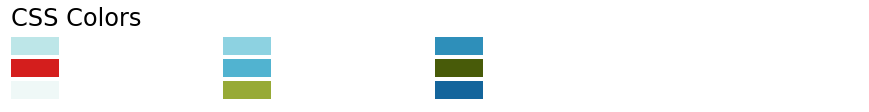

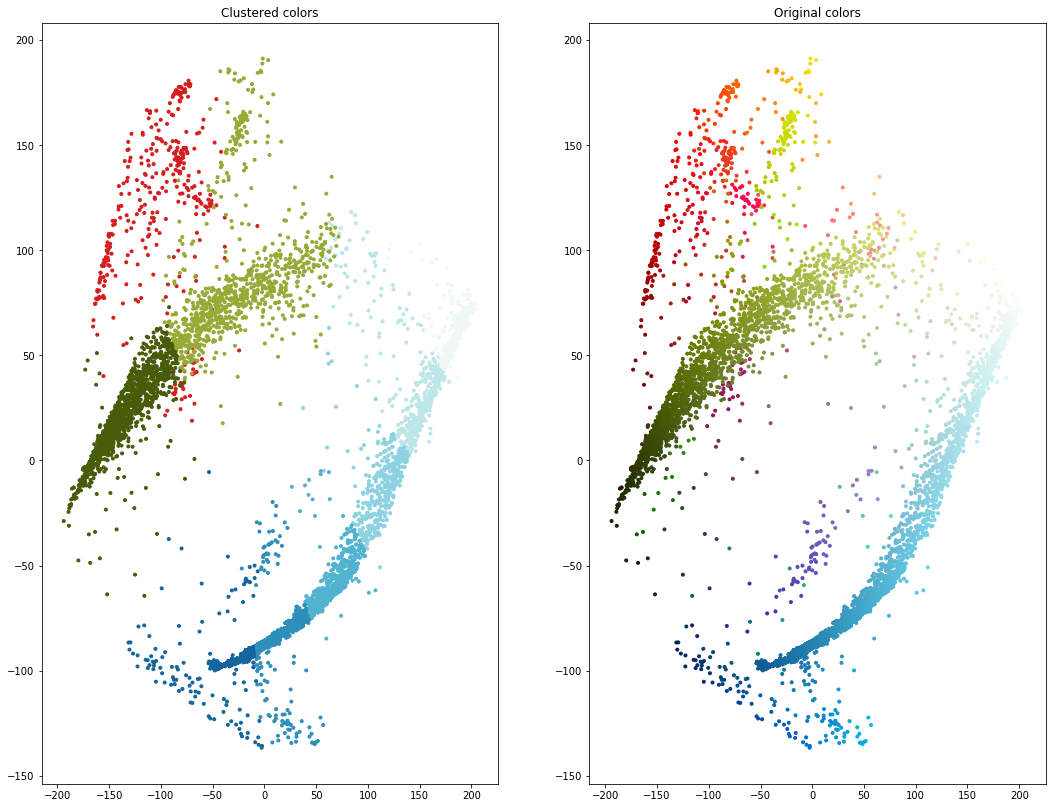

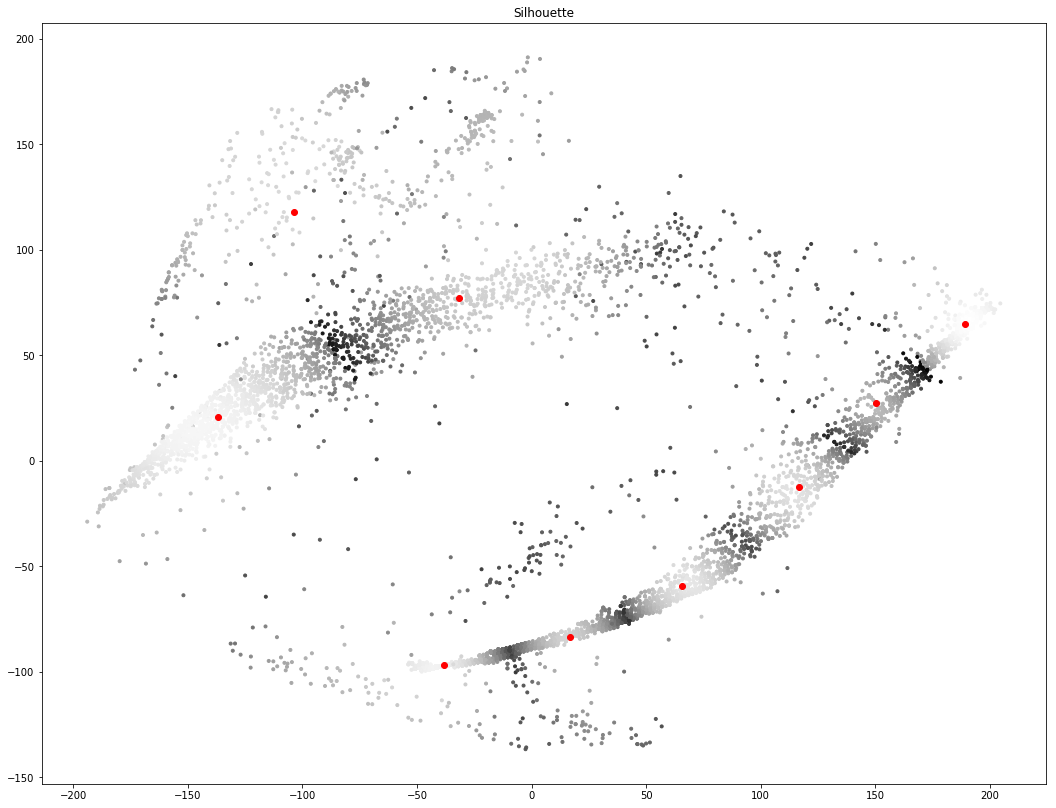

In [70]:
present(k=9)

Możemy zauważyć, że kolory klastów i ogyginalne są zbliżone.

W bliskim sąsiedztwie środków klastrów zaznaczonych na wizualizacji "Silhouette" widzimy, że kolory punktów są jaśniejsze. Jest to oznaka wysokiego indeksu Silhouette oznaczjąca dobre dopasowanie punktu do klastra.

In [88]:

def get_score(pts:np.ndarray,C):
    labels =np.zeros((pts.shape[0],))
    for label,indices in C.items():
        labels[indices] = label
    return davies_bouldin_score(pts,labels)
        
    

def get_avg_score(pts:np.ndarray,k,repeats:int,D)-> float:
        scores = []
        for _ in range(repeats):
            M, C = kmedoids.kMedoids(D, k)
            score = get_score(pts,C)
            scores.append(score)
        return np.average(scores),np.std(scores)

def get_opt_k(pts:np.ndarray, k_max=16, repeat=10):
    D = pairwise_distances(pts, metric='euclidean')
    return [(k,get_avg_score(pts,k,repeat,D)) for k in range(2, k_max)]



In [89]:
opt_k_results = get_opt_k(P)

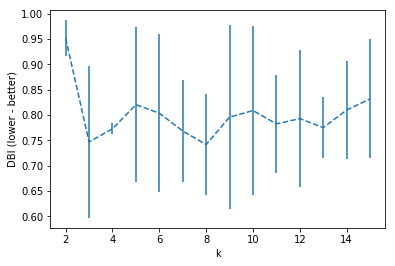

In [91]:
x=list(map(lambda x:x[0],opt_k_results))
y=list(map(lambda x:x[1][0],opt_k_results))
yerr=list(map(lambda x:x[1][1],opt_k_results))
plt.ylabel("DBI (lower - better)")
plt.xlabel("k")
plt.errorbar(x, y, yerr = yerr, barsabove=True,  fmt='--')
plt.show()

Możemy zobaczyć, że indeks DBi wskazuje, że na moim obrazku najlepiej jest wyróżnić 3, lub 8 kolorów.

Wykres jest podobny do wykresu *złego* obrazka z zadania poprzedniego (Random Initialization), być może należało. Prawdopodobnie gdyby wybrać obrazek o nieco mniejszej różnorodności kolorów, znalezienie optymalego k byłoby bardziej jednoznaczne.